# Weather Analysis using Python

Authors: Edwin Bosch and Calvin Kreusser

## Summary
This project is meant to collect and analyze weather data. The data comes from the National Weather Service and more specifically, their site reporting the current conditions at Centennial Airport (link below). Once per hour our script collected multiple pieces of weather data from the site including temperature, barometric pressure, wind conditions, and more. The data was then cleaned, numericized, and analyzed in this workbook. The introduction walks you through a rough idea of how we decided to categorize this data before we dive into the analysis.

 *https://forecast.weather.gov/MapClick.php?lat=39.570119444000056&lon=-104.84929444399995*

In [131]:
# code to set-up the google enviornment
from google.colab import drive
google_drive_root='Weather Scraping'
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/' + google_drive_root + '/'
drive.mount(google_drive_mount_location, force_remount=True)

Mounted at /content/drive


In [132]:
!pip install windrose
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from windrose import WindroseAxes
from wordcloud import WordCloud
from apyori import apriori

## Introduction
An interesting way to visualize the data is a word map which uses the conditions and the forecasts. First, I will do a bit of soft cleaning to focus the strings on weather.

In [134]:
def string_clean(string_guy):
    return string_guy[string_guy.find(":")+1:]

df1 = pd.read_csv(google_file_prefix + "weather_data.csv")
df1["Short term forecast"] = df1["Short term forecast"].apply(string_clean)
df1["2-day forecast"] = df1["2-day forecast"].apply(string_clean)
df1["4-day forecast"] = df1["4-day forecast"].apply(string_clean)

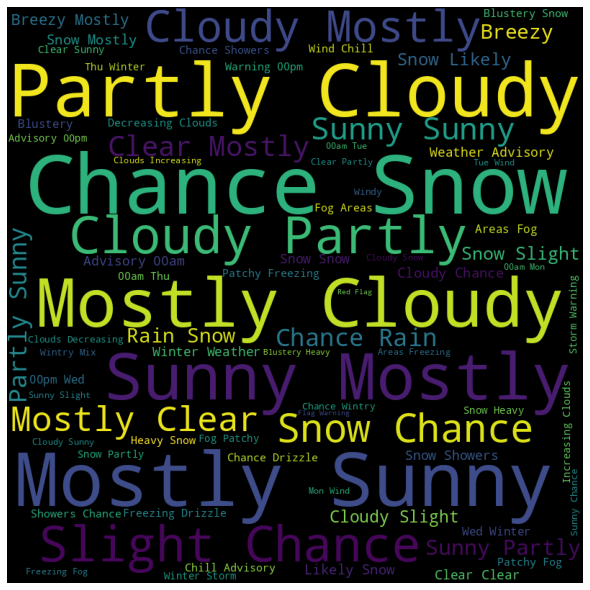

In [135]:
combined_str = ' '.join(df1["Short term forecast"].tolist() + df1["2-day forecast"].tolist() + df1["4-day forecast"].tolist())
wordcloud = WordCloud(width=800, height=800, min_font_size=10, random_state=12).generate(combined_str)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Clearly some more work is needed to categorize these terms into a numerical format. The function below is only one of many steps that were taken.

In [136]:
def string_fixer(string_guy):
    fixed_string = string_guy[string_guy.find(":") + 2:]
    if ":" in fixed_string:
        fixed_string = fixed_string[fixed_string.find(":") + 2:]
    if "then" in fixed_string:
        fixed_string = fixed_string[:fixed_string.find("then") - 1]
    if "and Areas Fog" in fixed_string:
        fixed_string = fixed_string[:-13]
    if "Areas " in fixed_string:
        fixed_string = fixed_string[6:]
    if "Slight Chance" in fixed_string:
        fixed_string = fixed_string.replace("Slight Chance ", "").strip()
    if "Chance" in fixed_string:
        fixed_string = fixed_string.replace("Chance ", "").strip()
    if "Likely" in fixed_string:
        fixed_string = fixed_string.replace(" Likely", "").strip()
    return fixed_string

In [137]:
df1 = pd.read_csv(google_file_prefix + "weather_data.csv")
df1["Short term forecast"] = df1["Short term forecast"].apply(string_fixer)
df1["2-day forecast"] = df1["2-day forecast"].apply(string_fixer)
df1["4-day forecast"] = df1["4-day forecast"].apply(string_fixer)

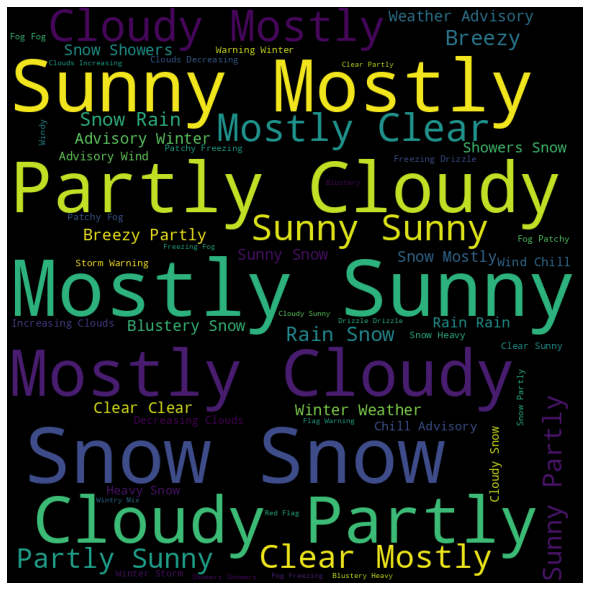

In [138]:
combined_str = ' '.join(df1["Short term forecast"].tolist() + df1["2-day forecast"].tolist() + df1["4-day forecast"].tolist())

wordcloud = WordCloud(width=800, height=800, random_state=12, min_font_size=10).generate(combined_str)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

This gives us a better idea of what conditions occurred and were predicted. However, to give the forecasts the credit they are due, things like "Winter Weather" and "Snow" need to be interpreted as the same value. This can only be done with categorization. Ultimately, arbitrary choices had to be made, and we chose to focus primarily on cloud cover. The "key_dictionary" file shows how each term was ultimately labeled. Let's move on to the cleaned data for a last visualization of how those choices affected our analysis.

In [139]:
# load data
df = pd.read_csv(google_file_prefix + "cleaned_data.csv")

Text(0.5, 0, 'Category')

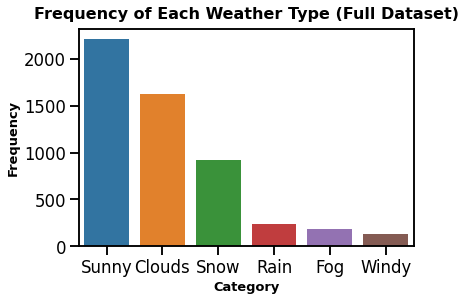

In [140]:
col_ob = pd.concat([df["Current Conditions"], df["Short term forecast"], df["2-day forecast"], df["4-day forecast"]], axis=0)
category_counts = col_ob.value_counts().rename({5: "Sunny", 4: "Clouds",3: "Windy",2: "Rain",1: "Fog",0: "Snow"})
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Frequency of Each Weather Type (Full Dataset)", pad=10, fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontweight='bold', fontsize=13)
plt.xlabel("Category", fontweight='bold', fontsize=13)

Text(0.5, 0, 'Category')

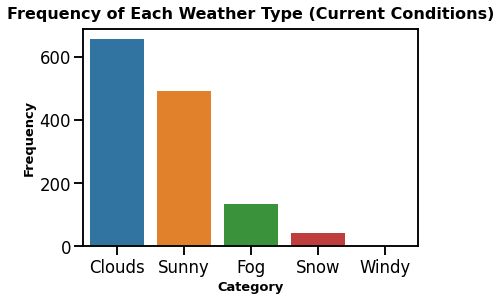

In [141]:
category_counts = df["Current Conditions"].value_counts().rename({5: "Sunny", 4: "Clouds",3: "Windy",2: "Rain",1: "Fog",0: "Snow"})

sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Frequency of Each Weather Type (Current Conditions)", pad=10, fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontweight='bold', fontsize=13)
plt.xlabel("Category", fontweight='bold', fontsize=13)

This last graph is for the actual conditions. Category 2 did not occur (no rain during the observation period) and Category 3 occurred perhaps once or twice when it was particularly windy. This difference in graphs explains why the forecasts will appear at least partly worse than they probably are. This is an unavoidable outcome when fitting English forecast terms into less-descriptive numeric values.

# Forecast Analysis

## Short-Term

Now that we have our cleaned and categorized data, let's look at the short-term forecast.

In [142]:
# how many hours is "soon"?
short_term = 5

In [143]:
def time_matcher(dat, interval):
    # this function gets the current conditions offset by the amount given. assumes time and current conditions column names
    output = []
    for i in range(interval, len(dat["Time"])):
        cur_time = dat["Time"][i]
        # find value for the needed time
        needed_time = (cur_time+interval)%24
        # search from current i to find the next occurrence of our time
        index = 0
        for k in range(i, i+24):
            # print(k)
            if k == len(dat)-1:
                break
            if df["Time"][k] == needed_time:
                index = k
            else:
                index = i+interval
        true_val = dat["Current Conditions"][k]
        output.append(true_val)
    return pd.DataFrame(output)

In [144]:
y_pred = df["Short term forecast"].iloc[short_term:].reset_index(drop=True)
y_true = time_matcher(df, short_term)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate the precision, recall, f1-score, and support
# this change was necessary as there are no 2s in the test data due to winter (include in report)
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

Accuracy: 0.3207261724659607
Precision: 0.4179313044866384
Recall: 0.3207261724659607
F1-Score: 0.3432528012667823


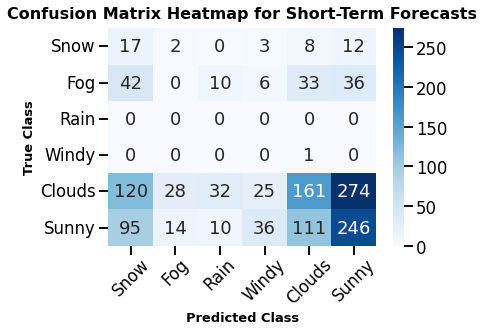

In [145]:
# Plot heatmap of confusion matrix
groups = ["Snow", "Fog", "Rain", "Windy", "Clouds", "Sunny"]
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=groups, yticklabels=groups)
ax.set_xticklabels(groups, rotation=45)
ax.tick_params(axis='x', pad=0)
plt.xlabel('Predicted Class', fontweight='bold', fontsize=13)
plt.ylabel('True Class', fontweight='bold', fontsize=13)
plt.title('Confusion Matrix Heatmap for Short-Term Forecasts', pad=10, fontsize=16, fontweight='bold')


# Display the plot
plt.show()

This data is quite interesting for a few reasons. Clearly the time of year has a heavy impact on the type of weather that exists and that we can analyze. It would also seem that short-term forecasts often predict snow when clouds or fog are what occur. This is likely a remnant of the categorization of the weather, and this confusion matrix highlights that the categories are a key factor in how we analyze the data. Another possible explanation is the need for the NWS to notify people of potential adverse weather events (Winter Storm, Red Flag Warning) even if the event ends up being less severe than predicted.

## 2-Day Forecasts

In [146]:
y_pred = df["2-day forecast"].iloc[48:].reset_index(drop=True)
y_true = time_matcher(df, 48)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate the precision, recall, f1-score, and support
# this change was necessary as there are no 2s in the test data due to winter (include in report)
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

Accuracy: 0.3706020328381548
Precision: 0.45185537220496985
Recall: 0.3706020328381548
F1-Score: 0.3914900699676302


Text(0.5, 1.0, 'Confusion Matrix Heatmap (2-Day Forecast)')

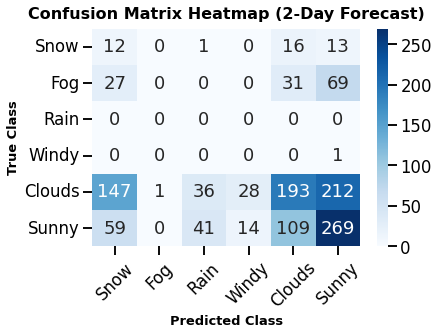

In [147]:
# Plot heatmap of confusion matrix
groups = ["Snow", "Fog", "Rain", "Windy", "Clouds", "Sunny"]
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=groups, yticklabels=groups)
ax.set_xticklabels(groups, rotation=45)
ax.set_yticklabels(groups, rotation=0)
plt.xlabel('Predicted Class', fontweight='bold', fontsize=13)
plt.ylabel('True Class', fontweight='bold', fontsize=13)
plt.title('Confusion Matrix Heatmap (2-Day Forecast)', pad=10, fontsize=16, fontweight='bold')

## 4-Day Forecasts

In [148]:
y_pred = df["4-day forecast"].iloc[96:].reset_index(drop=True)
y_true = time_matcher(df, 96)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate the precision, recall, f1-score, and support
# this change was necessary as there are no 2s in the test data due to winter (include in report)
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

Accuracy: 0.25995125913891143
Precision: 0.3504323304972852
Recall: 0.25995125913891143
F1-Score: 0.28257150184523006


Text(0.5, 1.0, 'Confusion Matrix Heatmap (4-Day Forecast)')

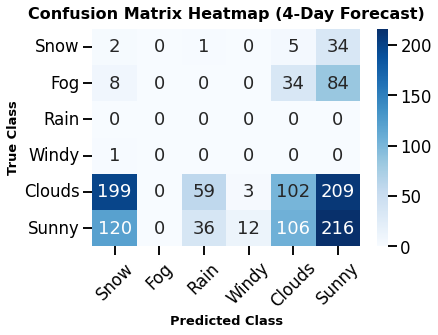

In [149]:
# Plot heatmap of confusion matrix
groups = ["Snow", "Fog", "Rain", "Windy", "Clouds", "Sunny"]
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=groups, yticklabels=groups)
ax.set_xticklabels(groups, rotation=45)
ax.set_yticklabels(groups, rotation=0)
plt.xlabel('Predicted Class', fontweight='bold', fontsize=13)
plt.ylabel('True Class', fontweight='bold', fontsize=13)
plt.title('Confusion Matrix Heatmap (4-Day Forecast)', pad=10, fontsize=16, fontweight='bold')

The over-arching pattern from both the analysis values and the heatmaps would seem to be that forecasts become less accurate the further into the future they are predicting. It is also important to reiterate that how we chose to classify weather and the categories that exist are very important to evaluating the forecasts. Now let's move on to a random forest to examine feature importance.

# Random Forest

In [150]:
df = pd.read_csv(google_file_prefix + "cleaned_data.csv")
X = df.drop(labels=["Current Conditions", "Short term forecast", "2-day forecast", "4-day forecast"], axis=1)
y = df["Current Conditions"]

# NOTE: this is technically time-series data but that form of analysis is not
# appropriate given the high degree of seasonality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1202)
feature_names = X.columns

forest = RandomForestClassifier(random_state=1023)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
y_true = y_test

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate the precision, recall, f1-score
# this change was necessary as there are no 2s (or 3s) in the test data
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

conf_matrix = confusion_matrix(y_true, y_pred)

Accuracy: 0.7857142857142857
Precision: 0.7950768641348595
Recall: 0.7857142857142857
F1-Score: 0.7798515081409818


Text(0.5, 1.0, 'Confusion Matrix Heatmap (Random Forest)')

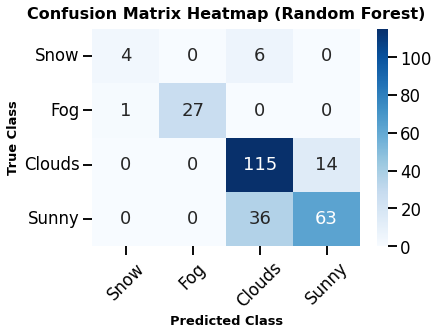

In [151]:
# Plot heatmap of confusion matrix
# wind did not appear in the test dataset (0.2 of all current conditions)
groups = ["Snow", "Fog", "Clouds", "Sunny"]
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=groups, yticklabels=groups)
ax.set_xticklabels(groups, rotation=45)
ax.set_yticklabels(groups, rotation=0)
ax.set_yticklabels(groups)
plt.xlabel('Predicted Class', fontweight='bold', fontsize=13)
plt.ylabel('True Class', fontweight='bold', fontsize=13)
plt.title('Confusion Matrix Heatmap (Random Forest)', pad=10, fontsize=16, fontweight='bold')

The random forest does not consider Rain (Category 2) as it does not appear in the data as a true value. It also does not consider Wind (Category 3) as it does not appear in the testing dataset. These omitted values required using a different evaluation metric to avoid a divide by zero error. 

It seems the random forest is excellent at identifying Fog. This is because it considers the current conditions, including visibility, and this gives it a strong advantage over the forecasts. It does struggle somewhat to differentiate between Clouds and Sunny, which is reasonable given that its predictive factors make it hard to tell how much cloud cover there is.

## Feature Importance

Let's look at feature importance using the random forest.

Text(0, 0.5, 'Mean Decrease in Impurity')

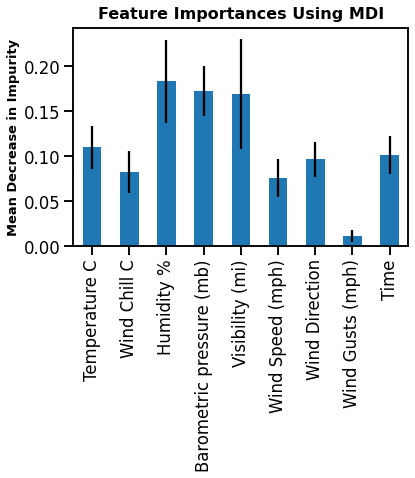

In [152]:
# feature importance using MDI
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances Using MDI", pad=10, fontsize=16, fontweight='bold')
ax.set_ylabel("Mean Decrease in Impurity", fontweight='bold', fontsize=13)

Text(0, 0.5, 'Mean accuracy decrease')

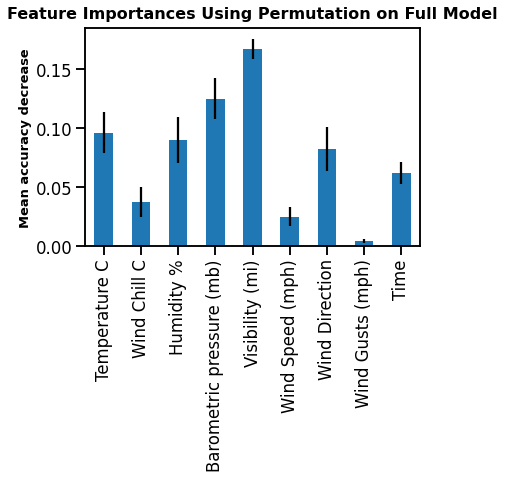

In [153]:
# feature importance using permutation
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full Model", pad=10, fontsize=16, fontweight='bold')
ax.set_ylabel("Mean accuracy decrease", fontweight='bold', fontsize=13)

These graphs are quite interesting for a few reasons. When we are predicting current weather conditions, especially given the importance our assignment function gives to cloud cover, visibility is a great indicator. Wind, humidity, barometric pressure, and the time of day are also reasonable predictors for weather, and so it makes sense that they would appear as key features.

# Association Analysis

In [154]:
# reload the data into a pandas dataframe
ap_data = pd.read_csv(google_file_prefix + "weather_data.csv")

# Convert the data into a list of lists, where each sublist represents a transaction
transactions = []
for i in range(len(ap_data)):
    transactions.append([str(ap_data.iloc[i, j]) for j in range(len(ap_data.columns))])

# Specify the minimum support and confidence
min_support = 0.082
min_confidence = 0.7

# Run the Apriori algorithm
results = list(apriori(transactions, min_support=min_support, min_confidence=min_confidence))

# dictionary to fix the wind chill issue
weather_dict = {"0": "No wind chill", "10.00 mi": "Maximum Visibility (10mi)",
                  "Calm": "No wind"}

# Print the results
for itemset in results:
    items = [x for x in itemset[0]]
    support = itemset[1]
    rules = itemset[2]
    for rule in rules:
        # Replace numbers with corresponding weather conditions from the dictionary
        antecedent = [weather_dict.get(x, x) for x in rule[0]]
        consequent = [weather_dict.get(x, x) for x in rule[1]]
        confidence = rule[2]
        print("Antecedent: ", antecedent)
        print("Consequent: ", consequent)
        print("Support: ", support)
        print("Confidence: ", confidence)
        print("\n")


Antecedent:  []
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.8547904191616766
Confidence:  0.8547904191616766


Antecedent:  ['No wind chill']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.19236526946107785
Confidence:  0.8801369863013698


Antecedent:  ['No wind']
Consequent:  ['No wind chill']
Support:  0.09880239520958084
Confidence:  1.0


Antecedent:  ['A Few Clouds']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.2252994011976048
Confidence:  0.9901315789473685


Antecedent:  ['No wind']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.08532934131736528
Confidence:  0.8636363636363636


Antecedent:  ['Fair']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.13922155688622753
Confidence:  1.0


Antecedent:  ['Mostly Cloudy']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.2522455089820359
Confidence:  0.9825072886297376


Antecedent:  ['Overcast']
Consequent:  ['Maximum Visibility (10mi)']
Support:  0.08982035928143713
Confidence:  0.92

Apriori association analysis is quite a different way of identifying relationships and patterns in the data. We have reloaded the raw data file and added a dictionary to clarify what some of the terms mean. It is quite clear where most of the association rules come from. The first rule simply indicates that most of the time, there is full visibility. No wind speed *always* indicates that there cannot be wind chill (thus confidence of 1.0). Some of the more interesting rules indicate that clear or mostly clear skies often indicate full visibility. The final rules show the strong relationship between the three most powerful indicators of clear weather: no wind (thus no wind chill) and full visibility. These rules give us confidence in the veracity of the data and identify clear associations but stop short of uncovering novel information. To find more associations every category should be lumped into baskets; however, this is non-trivial work that would not be reusable across models.

# Wind Direction

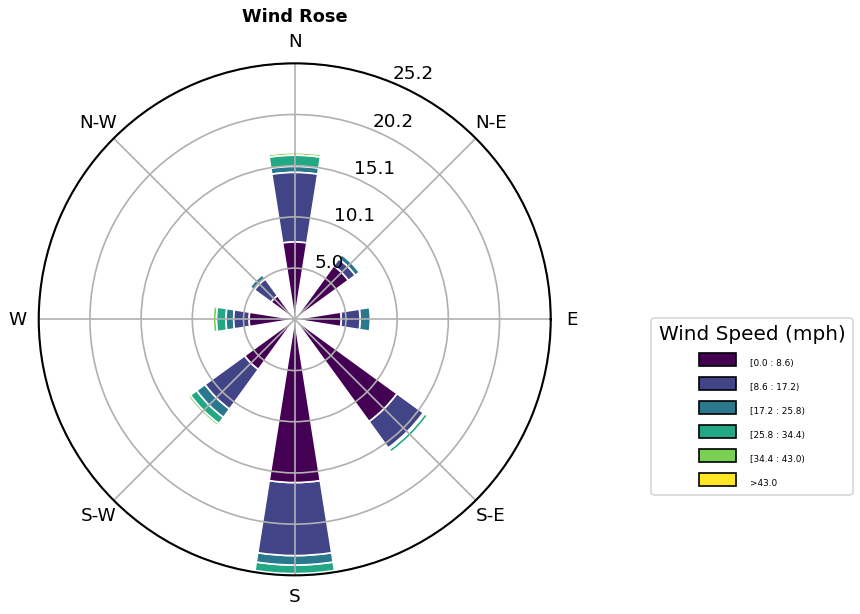

In [155]:
# add the wind column
direction_dict = {0: None, 1: 0, 2: 45, 3: 90, 4: 135, 5: 180, 6: 225, 7: 270, 8: 315}
df['Wind Direction (deg)'] = df['Wind Direction'].map(direction_dict)

ax = WindroseAxes.from_ax()

# Plot the wind rose
ax.bar(df['Wind Direction (deg)'], df['Wind Speed (mph)'], normed=True, opening=0.8, edgecolor='white')

# Customize the plot
ax.set_legend(title='Wind Speed (mph)', loc='upper left', bbox_to_anchor=(1.2, 0.5))
ax.set_title('Wind Rose', pad=10, fontsize=16, fontweight='bold')
plt.show()

This wind rose explains why both of Centennial Airport's runways face north to south, as planes are easiest to land into the wind. Keep in mind that a wind rose shows the direction the wind blows from. Thus, Northerly winds are the most common at our location. A more detailed look at satellite images of Centennial Airport gives a more granular idea of the wind direction: it almost always blows North to 350 degrees and south to 170 degrees.

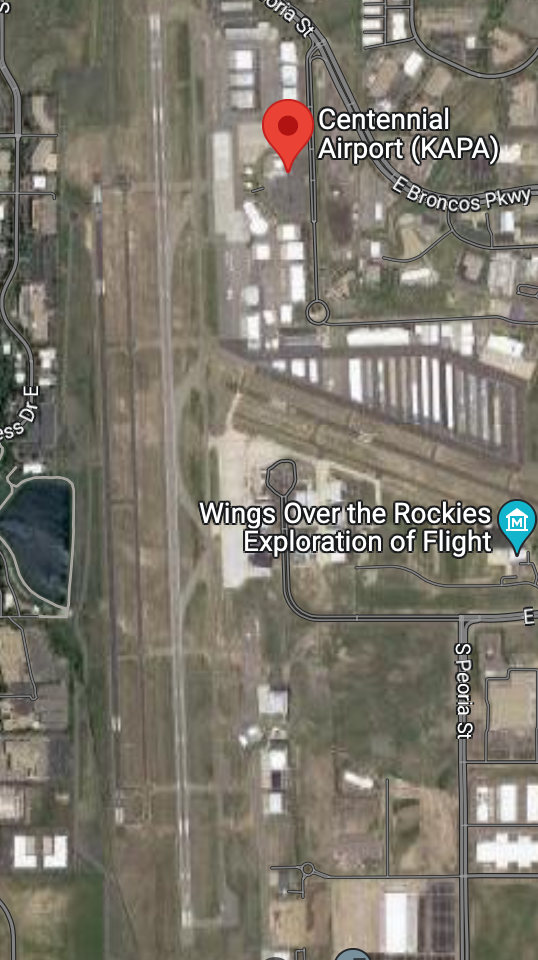

# Temporal Analysis

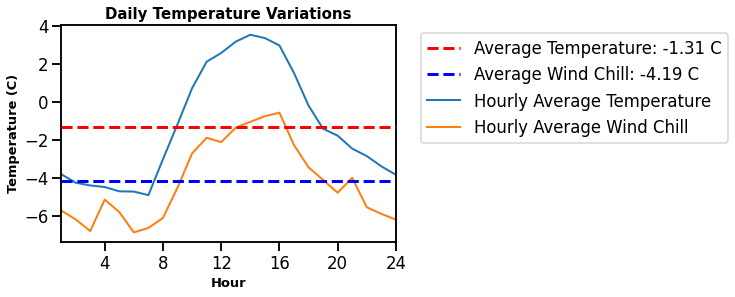

In [156]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Calculate the hourly average temperature and wind chill
hourly_avg_temp = df.groupby('Time')['Temperature C'].mean()
hourly_avg_wc = df.groupby('Time')['Wind Chill C'].mean()

# Create a horizontal line at the hourly average temperature and wind chill values
plt.axhline(hourly_avg_temp.mean(), color='red', linestyle='--', label=f'Average Temperature: {hourly_avg_temp.mean():.2f} C', linewidth=3, zorder=10)
plt.axhline(hourly_avg_wc.mean(), color='blue', linestyle='--', label=f'Average Wind Chill: {hourly_avg_wc.mean():.2f} C', linewidth=3, zorder=5)

# Plot the time series graphs for hourly average temperature and wind chill
plt.plot(hourly_avg_temp.index, hourly_avg_temp, label='Hourly Average Temperature', linewidth=2)
plt.plot(hourly_avg_wc.index, hourly_avg_wc, label='Hourly Average Wind Chill', linewidth=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([1, 24])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))

plt.title("Daily Temperature Variations", fontweight='bold', fontsize=15)
plt.xlabel('Hour', fontweight='bold', fontsize=13)
plt.ylabel('Temperature (C)', fontweight='bold', fontsize=13)

plt.show()


This graph is useful for understanding how temperature and wind chill vary on average over the course of the day.

Text(0, 0.5, 'Degrees Celsius')

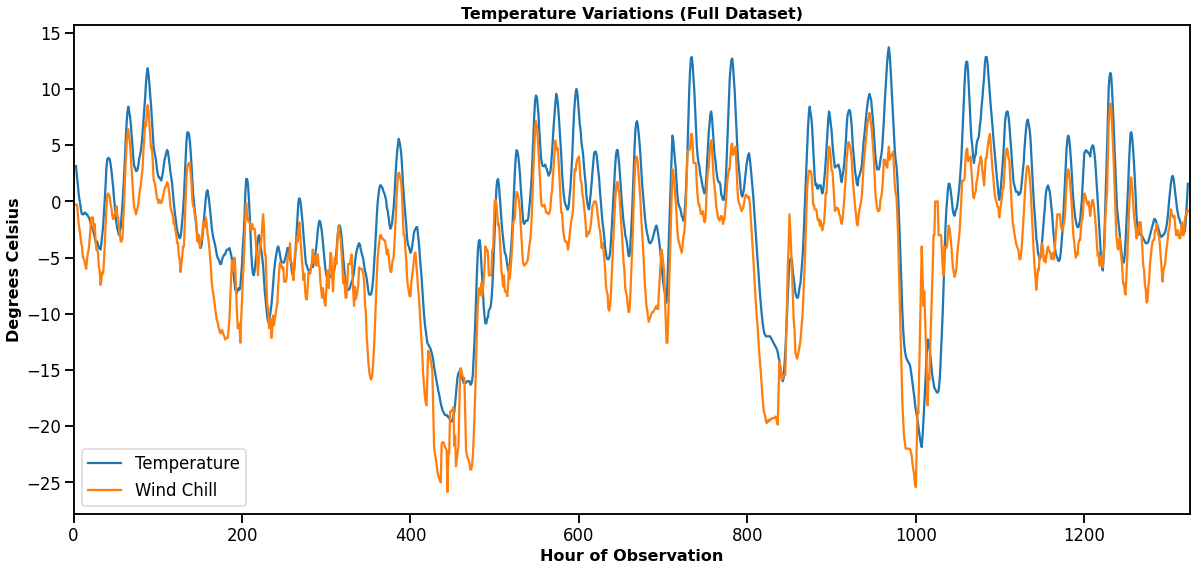

In [157]:
# bigger plot elements/ big plot
sns.set_context("talk")
plt.figure(figsize=(20,9))
sns.lineplot(x=df.index, y=df["Temperature C"].rolling(7).mean().shift(-3), 
            data=df, ci=None, label="Temperature")
sns.lineplot(x=df.index, y=df["Wind Chill C"].rolling(7).mean().shift(-3), 
            data=df, ci=None, label="Wind Chill")
plt.xlim([0, 1325])
plt.title("Temperature Variations (Full Dataset)", fontweight='bold', fontsize=16)
plt.xlabel("Hour of Observation", fontweight='bold', fontsize=16)
plt.ylabel("Degrees Celsius", fontweight='bold', fontsize=16)

This last graph allows us to see how the temperature and wind chill vary both on a daily scale, but also have a seasonal aspect which our observation did not last long enough to observe. A few key highlights are the data points at hours 400-500 (the last days of January through early February), when Denver received a cold snap seen clearly here. We also received another around hour 800 (about the middle of February) and a final one around February 23rd. The first cold snap *felt* particularly cold due to the deep wind chill which this graph demonstrates.